# Clan and coda type detection with Random Forest

> Can we get comparable results using a technique that doesn't require specialized NN training knowledge, doesn't require a GPU and lends itself well to interpretation?

In this notebook we will explore the performance of Random Forest. This is an often overlooked algorithm that is extremely powerful from a modelling perspective and also has the following characeteristics:

* can be run on the CPU
* doesn't require specialized neural network construction and training knowledge
* can tell us a lot about the data we are working with (lends itself well to interpetation)

You can learn more about this algorithm from this extremely valuable online resource: [Fastbook by Fast.ai chapter 9](https://github.com/fastai/fastbook/blob/master/09_tabular.ipynb)

## Clan detection

Let's grab the train and validation sets as dataframes.

In [1]:
from sperm_whale_bioacoustics.data import *
# from sperm_whale_bioacoustics import model_pretrain

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import pandas as pd
import numpy as np

In [2]:
train_clan = datasets_clan.items.iloc[datasets_clan.splits[0]]
valid_clan = datasets_clan.items.iloc[datasets_clan.splits[1]]

In [3]:
X_train_clan = train_clan.iloc[:, 4:13]
y_train_clan = train_clan.Clan

X_valid_clan = valid_clan.iloc[:, 4:13]
y_valid_clan = valid_clan.Clan

In [4]:
clf = RandomForestClassifier()
clf.fit(X_train_clan, y_train_clan);

clf.score(X_valid_clan, y_valid_clan)

0.9526315789473684

95.3% accuracy is the performance we would get out of `RandomForestClassifier` without any hyperparam tuning! This is slightly better than our RNN result with just a couple of lines of code!

Quite interestingly, it is also the exact result reported in the paper!

Let's see if we can do better with extensive parameter tuning. Note that throughout this procedure we don't show our validation set to the model for training or evaluation - this reduces the risk of overitting hyperparameter values to our validation set.

In [5]:
params = {
    'n_estimators': [300, 600, 1000, 1500, 2000, 4000, 10000],
    'min_samples_leaf': [1, 2],
    'max_features': [0.3, 0.5, 0.7, 1.0],
    'max_samples': [0.1, 0.3, 0.5, 0.7, 0.9, 1]
}

search = GridSearchCV(RandomForestClassifier(), params, n_jobs=-1, cv=3)

In [6]:
%time search.fit(X_train_clan, y_train_clan);

CPU times: user 13 s, sys: 252 ms, total: 13.2 s
Wall time: 10min 26s


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [7]:
search.best_params_

{'max_features': 0.5,
 'max_samples': 0.9,
 'min_samples_leaf': 1,
 'n_estimators': 4000}

In [8]:
search.best_estimator_.score(X_valid_clan, y_valid_clan)

0.9473684210526315

This doesn't improve our results. Seems slightly stronger performance than our RNN model and minimally below the results in the paper is where we need to stop.

Let's take a look at model interpretation.

In [9]:
m = search.best_estimator_ # storing the model in the `m` variable so that we can access it with ease for later use

## Model interpretation

The model can classify examples up to a high degree accuracy. Can it tell us which features have it found most telling, most important for the task of discerning the clan membership?

Yes, it can!

### Feature importance

In [10]:
# grabbing the code directly from https://github.com/fastai/fastbook/blob/master/09_tabular.ipynb
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [11]:
rf_feat_importance(m, X_valid_clan)

,cols,imp
3,ICI4,0.404468
2,ICI3,0.301419
0,ICI1,0.084432
1,ICI2,0.082337
4,ICI5,0.061908
5,ICI6,0.043144
6,ICI7,0.014105
7,ICI8,0.005540
8,ICI9,0.002647


We get a listing of features in order of their relative importance, of how much they contributed to making the predictions relative to each other.

We can see that interclick interval #4 is most telling followed by ICI3 and than there is a large distance and ICI1 follows.

What else can we learn about whale communication?

### Correlation between columns in our dataset

The following doesn't make use of the model that we trained, but it is also an interesting question to ask - which interclick intervals (in terms of duration) track each other most closely?

In [12]:
# code taken from https://github.com/fastai/fastbook/blob/master/utils.py

from scipy.cluster import hierarchy as hc
import numpy as np
import scipy
import matplotlib.pylab as plt

def cluster_columns(df, figsize=(10,6), font_size=12):
    corr = np.round(scipy.stats.spearmanr(df).correlation, 4)
    corr_condensed = hc.distance.squareform(1-corr)
    z = hc.linkage(corr_condensed, method='average')
    fig = plt.figure(figsize=figsize)
    hc.dendrogram(z, labels=df.columns, orientation='left', leaf_font_size=font_size)
    plt.show()

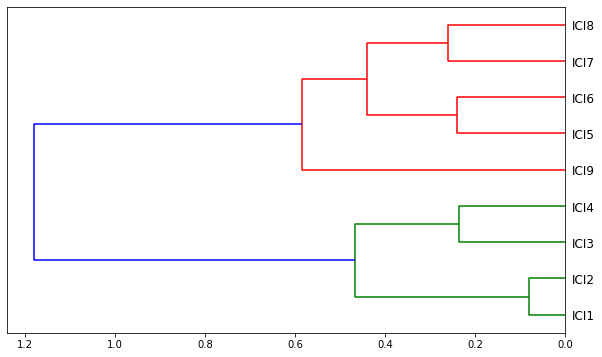

In [13]:
cluster_columns(X_train_clan)

We see that ICI1 tracks the duration of ICI2, ICI3 the duration of ICI4, and so on. It also seems that the last, very infrequent ICI9, seems more independent.

This reinforces the sequential structure of a coda - the duration of an ICI is overall most closely related to the duration of the surrounding ICIs.

### Partial dependence

Let's go back to querying our model and construct partial dependence plots. This is a technique that allows us to answer the following question: if the only thing that varied was a given column, say ICI4, how would that affect the prediction?

From the above considerations we know that ICI4 plays a key role in discerning between the clans. But what values of the ICI4 are most associated with each clan? Let's find out.

In [14]:
from sklearn.inspection import plot_partial_dependence

In [15]:
m.classes_

array(['EC1', 'EC2'], dtype=object)

Text(0.5, 0.98, 'Partial dependence plots for EC2')

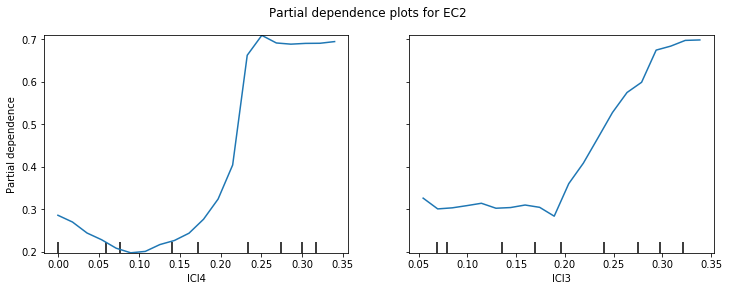

In [16]:
fig,ax = plt.subplots(figsize=(12, 4))
plot_partial_dependence(
    m,
    X_valid_clan,
    ['ICI4', 'ICI3'],
    grid_resolution=20,
    target=['EC1', 'EC2'],
    ax=ax);

plt.gcf().suptitle('Partial dependence plots for EC2')

We can see that there is a sharp jump roughly around 0.20 for ICI4. Once it crosses this threshold it immediately becomes a very strong indication that the coda orignated from a whale belonging to the EC2 clan.

With ICI3 the shift is more gradual - shorter intervals are associated with belonging to the EC1 clan and and association with the EC2 clan becomes linearly more probably as the interval grows past the 0.20 mark.

### Understanding predictions on single example

As we explore our data, we might be interested in understanding why our model made this specific prediction on a given row or data.

To this effect, we can use this very handy waterfall chart.

In [17]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

from treeinterpreter import treeinterpreter
from waterfall_chart import plot as waterfall

In [18]:
prediction,bias,contributions = treeinterpreter.predict(m, X_valid_clan.iloc[100].values.reshape(1,-1))

Our model is convinced the whale belongs to the EC1 clan.

In [19]:
y_valid_clan.iloc[100]

'EC1'

And it is right! Let's see how it arrived at this prediction.

In [20]:
X_valid_clan.columns

Index(['ICI1', 'ICI2', 'ICI3', 'ICI4', 'ICI5', 'ICI6', 'ICI7', 'ICI8', 'ICI9'], dtype='object')

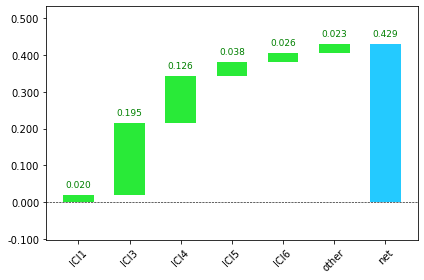

In [21]:
# code take from https://github.com/fastai/fastbook/blob/master/09_tabular.ipynb

waterfall(X_valid_clan.columns, contributions[0][:, 0], threshold=0.08, 
          rotation_value=45,formatting='{:,.3f}');

For this particular example the durations of the listed ICIs all suggest, according to the model, that the whale belongs to the EC1. We can also see that the ICI3 was particularly indicative.

This is an unparalleled level of information that our model provides and does so with relative ease. It's performance falls slightly short of the performance of the RNN reported in the paper, nonetheless it facilitates carrying out a very detailed analysis of our data. It also doesn't require specialized hardware and allows a person carrying out the inquiry to arrive at the results much quicker than should they have to piece together training an RNN (even with a tool facilitating rapid prototyping like thie `fastai` library)

## Coda type detection

We will now attempt coda type detection using Random Forest. Let's see how we will fare on this task.

In [22]:
train_coda = datasets_coda.items.iloc[datasets_coda.splits[0]]
valid_coda = datasets_coda.items.iloc[datasets_coda.splits[1]]

In [23]:
X_train_coda = train_coda.iloc[:, 4:13]
y_train_coda = train_coda.CodaType

X_valid_coda = valid_coda.iloc[:, 4:13]
y_valid_coda = valid_coda.CodaType

In [24]:
X_train_coda.shape, X_valid_coda.shape

((7228, 9), (804, 9))

In [25]:
clf = RandomForestClassifier()
clf.fit(X_train_coda, y_train_coda);

clf.score(X_valid_coda, y_valid_coda)

0.996268656716418

In the paper, an accuracy of 99.9% is achieved on the validation set, so we are not far off! Let's see if we can improve our results by tuning the hyperparameters.

In [26]:
params = {
    'n_estimators': [300, 600, 1000, 1500, 2000, 4000, 10000],
    'min_samples_leaf': [1, 2],
    'max_features': [0.3, 0.5, 0.7, 1.0],
    'max_samples': [0.1, 0.3, 0.5, 0.7, 0.9, 1]
}

search = GridSearchCV(RandomForestClassifier(), params, n_jobs=-1, cv=3)

In [27]:
%time search.fit(X_train_coda, y_train_coda);

CPU times: user 5.96 s, sys: 192 ms, total: 6.15 s
Wall time: 24min 53s


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [28]:
search.best_params_

{'max_features': 0.3,
 'max_samples': 0.7,
 'min_samples_leaf': 1,
 'n_estimators': 300}

In [29]:
search.best_estimator_.score(X_valid_coda, y_valid_coda)

0.996268656716418

No improvement, 99.6% accuracy remains as our result!

Given the result, the most interesting question that comes to mind is which examples the model got wrong? Are they mislabled data? Is there something specific about these examples that trips our model?

In [30]:
m = search.best_estimator_

In [31]:
preds = m.predict(X_valid_coda)
preds[:10]

array(['1+1+3', '1+1+3', '5R1', '1+1+3', '1+1+3', '1+1+3', '4D', '1+1+3',
       '4R2', '3D'], dtype=object)

In [32]:
np.where(preds != y_valid_coda.values)

(array([274, 320, 523]),)

Just three examples that our model missed! This is what they look like

In [33]:
X_valid_coda.iloc[np.where(preds != y_valid_coda.values)[0]]

,ICI1,ICI2,ICI3,ICI4,ICI5,ICI6,ICI7,ICI8,ICI9
1697,0.27080,0.3293,0.161000,0.0,0.0,0.0,0.0,0.0,0.0
564,0.17100,0.0870,0.080000,0.0,0.0,0.0,0.0,0.0,0.0
5946,0.14125,0.1657,0.152017,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
y_valid_coda.iloc[np.where(preds != y_valid_coda.values)[0]]

1697     4R2
564      4R1
5946    1+31
Name: CodaType, dtype: object

I am not a domain expert, so it is hard for me to comment what went wrong here. Let us nonetheless try to understand better why our model made the prediction it did.

These are it's predictions

In [35]:
m.predict(X_valid_coda.iloc[np.where(preds != y_valid_coda.values)[0]])

array(['1+31', '1+32', '4R1'], dtype=object)

Taking look at the first one

In [36]:
idx = np.where(preds != y_valid_coda.values)[0][0]
prediction,bias,contributions = treeinterpreter.predict(m, X_valid_coda.iloc[idx].values.reshape(1,-1))

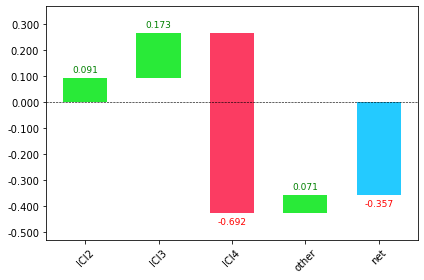

In [37]:
waterfall(X_valid_coda.columns, contributions[0][:, 0], threshold=0.08, 
          rotation_value=45,formatting='{:,.3f}');

We can see that the model found the ICI3 followed by ICI2 telling, while the highest contribution to the predction came from the ICI4 being equal to 0 (not surprisingly, that is a very strong indication to not even consider quite a few of the labels).

## Summary

Results of our Random Forest models:
    
### Clan detection

|model|accuracy|
|:------:|:-----------|
|RNN (paper)|95.3%|
|RNN (ours) |93.7%|
|Random Forest |94.7%|

### Coda type detection

|model|accuracy|
|:------:|:-----------|
|RNN (paper)|99.9%|
|RNN (ours) |100%|
|Random Forest |99.6%|

Our RNN and Random Forest use the same sampling of the train and validation sets and thus these results are easiest to compare. The paper followed a different sampling of the train and validation sets.

Overall, the differences in performance, given the size of the validation set, are next to insignificant. All the models perform similarly.

An interesting result is the stronger performance of our Random Forest as compared to our RNN on the clan detection task.

We found no benefits to pretraining. For RNNs we got best results when training the entire model from scratch.

The main consideration that we would like to highlight is how much less compute and specialized knowledge was needed to get good results with Random Forest. Above all, the interpretability of the model is unparalleled. The robustness of the method to training on unbalanced data and its legendary ability to not overfit (while still packing enough variance to give good results) makes this a great model to have in one's toolbox.